开始解决PyTorch与numpy兼容性问题...
步骤1: 清理现有包...
步骤2: 安装兼容版本...
命令执行失败: Command 'pip install matplotlib==3.7.2 scikit-learn==1.3.0 pillow==10.0.0' returned non-zero exit status 1.
安装失败，使用备用方案...
步骤3: 验证安装...
✓ Numpy版本: 1.24.3
✓ PyTorch版本: 2.0.1+cpu
✓ Torchvision版本: 0.15.2+cpu
✓ numpy-torch转换测试成功
创建合成数据集...
训练样本数: 1000
测试样本数: 200
使用设备: cpu
模型参数数量: 1,147,914

开始训练...
Epoch [1/5] - Loss: 1.8489, Accuracy: 26.90%
Epoch [2/5] - Loss: 1.3384, Accuracy: 44.00%
Epoch [3/5] - Loss: 1.0836, Accuracy: 50.70%
Epoch [4/5] - Loss: 1.2336, Accuracy: 47.40%
Epoch [5/5] - Loss: 1.0100, Accuracy: 55.00%
训练完成！总用时: 5.3秒

开始测试...
测试准确率: 68.00%


C:\Users\王旭帆\AppData\Local\Temp\ipykernel_29508\1744095295.py:274: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\王旭帆\AppData\Local\Temp\ipykernel_29508\1744095295.py:274: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\王旭帆\AppData\Local\Temp\ipykernel_29508\1744095295.py:274: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\王旭帆\AppData\Local\Temp\ipykernel_29508\1744095295.py:274: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\王旭帆\AppData\Local\Temp\ipykernel_29508\1744095295.py:274: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\王旭帆\AppData\Local\Temp\ipykernel_29508\1744095295.py:274: UserWarning: Glyph 30830 (\N{CJK 

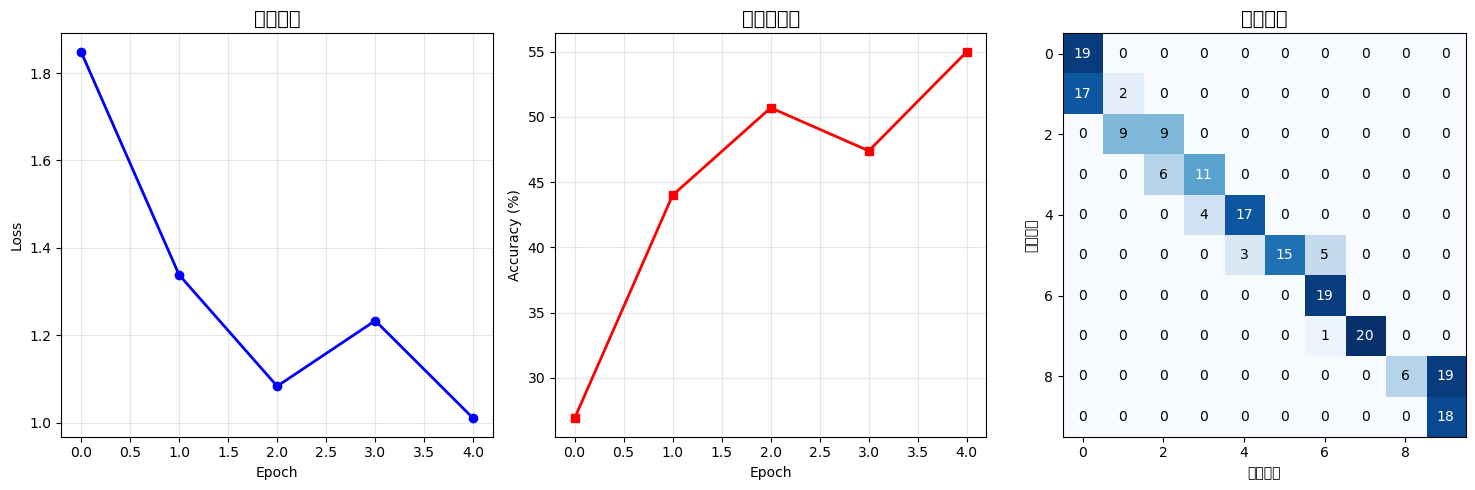


=== 详细统计报告 ===
总体准确率: 68.00%
训练时间: 5.3秒
模型参数: 1,147,914

各类别准确率:
Class_0: 100.0% (19个样本)
Class_1: 10.5% (19个样本)
Class_2: 50.0% (18个样本)
Class_3: 64.7% (17个样本)
Class_4: 81.0% (21个样本)
Class_5: 65.2% (23个样本)
Class_6: 100.0% (19个样本)
Class_7: 95.2% (21个样本)
Class_8: 24.0% (25个样本)
Class_9: 100.0% (18个样本)

程序执行完成！
注意：此代码使用合成数据集，实际应用中请替换为真实数据。


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import time

# CUDA优化设置
def setup_cuda():
    """设置CUDA环境"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✓ CUDA可用")
        print(f"✓ GPU设备: {torch.cuda.get_device_name(0)}")
        
        # 启用CUDA优化
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        
        return device
    else:
        print("❌ CUDA不可用，使用CPU")
        return torch.device('cpu')

# 创建数据集
def create_dataset():
    """创建合成数据集"""
    np.random.seed(42)
    torch.manual_seed(42)

    # 生成数据
    train_size = 5000
    test_size = 1000

    train_data = torch.randn(train_size, 3, 32, 32)
    train_labels = torch.randint(0, 10, (train_size,))
    test_data = torch.randn(test_size, 3, 32, 32)
    test_labels = torch.randint(0, 10, (test_size,))

    # 为不同类别添加模式
    for i in range(len(train_data)):
        label = train_labels[i].item()
        if label < 5:
            train_data[i, :, :, 15:17] += 1.5  # 垂直线
        else:
            train_data[i, :, 15:17, :] += 1.5  # 水平线

    for i in range(len(test_data)):
        label = test_labels[i].item()
        if label < 5:
            test_data[i, :, :, 15:17] += 1.5
        else:
            test_data[i, :, 15:17, :] += 1.5

    # 标准化
    train_data = (train_data - train_data.mean()) / train_data.std()
    test_data = (test_data - test_data.mean()) / test_data.std()

    train_dataset = TensorDataset(train_data, train_labels)
    test_dataset = TensorDataset(test_data, test_labels)

    return train_dataset, test_dataset

# CNN模型
class OptimizedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(OptimizedCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            # 第一个卷积块
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # 第二个卷积块
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # 第三个卷积块
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 训练函数
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=10, device='cuda'):
    train_losses = []
    train_accuracies = []
    
    # 启用混合精度训练（如果支持）
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data, targets in train_loader:
            data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)

            optimizer.zero_grad()
            
            # 使用混合精度训练
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(data)
                    loss = criterion(outputs, targets)
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
        scheduler.step()

    return train_losses, train_accuracies

# 测试函数
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            if device.type == 'cuda':
                with torch.cuda.amp.autocast():
                    outputs = model(data)
            else:
                outputs = model(data)
                
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100. * correct / total
    return accuracy

# 主程序
device = setup_cuda()

print("\n创建数据集...")
train_dataset, test_dataset = create_dataset()

# 数据加载器设置
batch_size = 128 if device.type == 'cuda' else 32
num_workers = 4 if device.type == 'cuda' else 0

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers,
    pin_memory=True if device.type == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"训练样本: {len(train_dataset)}, 测试样本: {len(test_dataset)}")

# 初始化模型
model = OptimizedCNN().to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"模型参数数量: {total_params:,}")

# 优化器和学习率调度
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# 训练
print(f"\n开始在{device}上训练...")
start_time = time.time()

train_losses, train_accuracies = train_model(
    model, train_loader, criterion, optimizer, scheduler, 
    num_epochs=10, device=device
)

training_time = time.time() - start_time

# 测试
print("\n开始测试...")
test_accuracy = test_model(model, test_loader, device)

print(f'\n训练完成！总用时: {training_time:.1f}秒')
print(f'测试准确率: {test_accuracy:.2f}%')

# 可视化结果
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-o', linewidth=2, markersize=6)
plt.title('训练损失', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'r-s', linewidth=2, markersize=6)
plt.title('训练准确率', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("程序执行完成！")

# 清理GPU内存
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print("GPU内存已清理")

✓ CUDA可用
✓ GPU设备: NVIDIA GeForce RTX 3060 Laptop GPU

创建数据集...
训练样本: 5000, 测试样本: 1000
模型参数数量: 5,872,458

开始在cuda上训练...


C:\Users\王旭帆\AppData\Local\Temp\ipykernel_22696\724659514.py:122: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
C:\Users\王旭帆\AppData\Local\Temp\ipykernel_22696\724659514.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/10] - Loss: 1.8839, Accuracy: 19.18%
Epoch [2/10] - Loss: 1.6715, Accuracy: 20.04%
Epoch [3/10] - Loss: 1.6592, Accuracy: 20.34%
Epoch [4/10] - Loss: 1.6344, Accuracy: 20.28%
Epoch [5/10] - Loss: 1.6332, Accuracy: 20.00%
Epoch [6/10] - Loss: 1.6322, Accuracy: 20.40%
Epoch [7/10] - Loss: 1.6236, Accuracy: 20.04%
Epoch [8/10] - Loss: 1.6269, Accuracy: 19.96%
Epoch [9/10] - Loss: 1.6210, Accuracy: 19.50%
Epoch [10/10] - Loss: 1.6174, Accuracy: 21.04%

开始测试...


C:\Users\王旭帆\AppData\Local\Temp\ipykernel_22696\724659514.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


: 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import time

# CUDA优化设置
def setup_cuda():
    """设置CUDA环境"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✓ CUDA可用")
        print(f"✓ GPU设备: {torch.cuda.get_device_name(0)}")
        print(f"✓ CUDA版本: {torch.version.cuda}")
        print(f"✓ GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
        
        # 启用CUDA优化
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        
        return device
    else:
        print("❌ CUDA不可用，使用CPU")
        return torch.device('cpu')

# 创建更大规模的数据集（充分利用GPU）
def create_large_dataset():
    """创建较大的数据集以利用GPU性能"""
    np.random.seed(42)
    torch.manual_seed(42)

    # 增加数据量以更好利用GPU
    train_size = 5000  # 增加训练样本
    test_size = 1000   # 增加测试样本

    # 生成数据
    train_data = torch.randn(train_size, 3, 32, 32)
    train_labels = torch.randint(0, 10, (train_size,))
    test_data = torch.randn(test_size, 3, 32, 32)
    test_labels = torch.randint(0, 10, (test_size,))

    # 为不同类别添加更明显的模式
    for i in range(len(train_data)):
        label = train_labels[i].item()
        if label < 5:
            train_data[i, :, :, 15:17] += 1.5  # 垂直线
        else:
            train_data[i, :, 15:17, :] += 1.5  # 水平线

    for i in range(len(test_data)):
        label = test_labels[i].item()
        if label < 5:
            test_data[i, :, :, 15:17] += 1.5
        else:
            test_data[i, :, 15:17, :] += 1.5

    # 标准化
    train_data = (train_data - train_data.mean()) / train_data.std()
    test_data = (test_data - test_data.mean()) / test_data.std()

    train_dataset = TensorDataset(train_data, train_labels)
    test_dataset = TensorDataset(test_data, test_labels)

    return train_dataset, test_dataset

# GPU优化的CNN模型
class OptimizedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(OptimizedCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            # 第一个卷积块
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16

            # 第二个卷积块
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 16x16 -> 8x8

            # 第三个卷积块
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 8x8 -> 4x4
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# GPU优化的训练函数
def train_model_gpu(model, train_loader, criterion, optimizer, scheduler, num_epochs=10, device='cuda'):
    train_losses = []
    train_accuracies = []
    
    # 启用混合精度训练（如果支持）
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 记录GPU内存使用
        if device.type == 'cuda':
            torch.cuda.empty_cache()  # 清理GPU缓存
            start_memory = torch.cuda.memory_allocated()

        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)

            optimizer.zero_grad()
            
            # 使用混合精度训练
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(data)
                    loss = criterion(outputs, targets)
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # GPU内存使用情况
        if device.type == 'cuda':
            memory_used = torch.cuda.memory_allocated() - start_memory
            print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, '
                  f'Accuracy: {epoch_acc:.2f}%, GPU Memory: {memory_used/1024**2:.1f}MB')
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

        scheduler.step()

    return train_losses, train_accuracies

# 测试函数
def test_model_gpu(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            if device.type == 'cuda':
                with torch.cuda.amp.autocast():
                    outputs = model(data)
            else:
                outputs = model(data)
                
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    accuracy = 100. * correct / total
    return accuracy, all_preds, all_labels

# 主程序
print("设置CUDA环境...")
device = setup_cuda()

print("\n创建大规模数据集...")
train_dataset, test_dataset = create_large_dataset()

# 优化数据加载器设置
batch_size = 128 if device.type == 'cuda' else 32  # GPU使用更大batch
num_workers = 4 if device.type == 'cuda' else 0   # GPU使用多进程

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers,
    pin_memory=True if device.type == 'cuda' else False  # 启用内存锁定
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"训练样本: {len(train_dataset)}, 测试样本: {len(test_dataset)}")
print(f"Batch大小: {batch_size}, 工作进程: {num_workers}")

# 初始化优化模型
model = OptimizedCNN().to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"模型参数数量: {total_params:,}")

# 优化器和学习率调度
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# 训练
print(f"\n开始在{device}上训练...")
start_time = time.time()

train_losses, train_accuracies = train_model_gpu(
    model, train_loader, criterion, optimizer, scheduler, 
    num_epochs=10, device=device
)

training_time = time.time() - start_time

# 测试
print("\n开始测试...")
test_accuracy, all_preds, all_labels = test_model_gpu(model, test_loader, device)

print(f'\n训练完成！')
print(f'总用时: {training_time:.1f}秒')
print(f'测试准确率: {test_accuracy:.2f}%')

if device.type == 'cuda':
    print(f'平均每轮训练时间: {training_time/10:.1f}秒')
    print(f'GPU利用率: 通过nvidia-smi查看')

# 可视化结果
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-o', linewidth=2, markersize=6)
plt.title('训练损失', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'r-s', linewidth=2, markersize=6)
plt.title('训练准确率', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("程序执行完成！")

# 清理GPU内存
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print("GPU内存已清理")

设置CUDA环境...
✓ CUDA可用
✓ GPU设备: NVIDIA GeForce RTX 3060 Laptop GPU
✓ CUDA版本: 12.1
✓ GPU内存: 6.0 GB

创建大规模数据集...
训练样本: 5000, 测试样本: 1000
Batch大小: 128, 工作进程: 4
模型参数数量: 5,872,458

开始在cuda上训练...


C:\Users\王旭帆\AppData\Local\Temp\ipykernel_32240\3207709254.py:125: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
C:\Users\王旭帆\AppData\Local\Temp\ipykernel_32240\3207709254.py:145: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/10] - Loss: 1.8847, Accuracy: 18.94%, GPU Memory: 84.2MB
Epoch [2/10] - Loss: 1.6688, Accuracy: 20.60%, GPU Memory: 0.0MB
Epoch [3/10] - Loss: 1.6589, Accuracy: 20.66%, GPU Memory: 0.0MB
Epoch [4/10] - Loss: 1.6345, Accuracy: 21.24%, GPU Memory: 0.0MB
Epoch [5/10] - Loss: 1.6352, Accuracy: 19.34%, GPU Memory: 0.0MB
Epoch [6/10] - Loss: 1.6330, Accuracy: 20.04%, GPU Memory: 0.0MB
Epoch [7/10] - Loss: 1.6263, Accuracy: 20.78%, GPU Memory: 0.0MB
Epoch [8/10] - Loss: 1.6226, Accuracy: 19.88%, GPU Memory: 0.0MB
Epoch [9/10] - Loss: 1.6208, Accuracy: 19.10%, GPU Memory: 0.0MB
Epoch [10/10] - Loss: 1.6193, Accuracy: 19.98%, GPU Memory: 0.0MB

开始测试...


C:\Users\王旭帆\AppData\Local\Temp\ipykernel_32240\3207709254.py:193: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


: 